# Import bibliotek

In [ ]:
!pip install ccxt ta

In [2]:
import ccxt
import pandas as pd
import numpy as np
import ta
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Funkcje

In [24]:
# Initialize the exchange
exchange = ccxt.binance()

# Function to fetch OHLCV data
def fetch_ohlcv(symbol, timeframe='1h', n_frames=10000):
    dataframe = pd.DataFrame(columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    since = exchange.parse8601( (datetime.utcnow() - timedelta(hours=n_frames)).isoformat() )
    timediff = exchange.parse8601( datetime.utcnow().isoformat() ) - since
    for i in range(1+n_frames//1000):
        temp_ohlcv = pd.DataFrame(exchange.fetch_ohlcv(symbol, timeframe, since=since+(timediff*i*1000//n_frames), limit=1000),columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        dataframe = pd.concat([dataframe, temp_ohlcv])
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], unit='ms')
    # Add technical indicators
    dataframe['SMA_50'] = ta.trend.SMAIndicator(close=dataframe['close'], window=50).sma_indicator()
    dataframe['SMA_200'] = ta.trend.SMAIndicator(close=dataframe['close'], window=200).sma_indicator()
    dataframe['RSI_14'] = ta.momentum.RSIIndicator(close=dataframe['close'], window=14).rsi()
    bb = ta.volatility.BollingerBands(close=dataframe['close'], window=20, window_dev=2)
    dataframe['BB_High'] = bb.bollinger_hband()
    dataframe['BB_Low'] = bb.bollinger_lband()
    dataframe.set_index('timestamp', inplace=True)
    return dataframe

def model_training(symbol, timeframe, n_frames):
    # Fetch data
    dataframe = fetch_ohlcv(symbol, timeframe=timeframe, n_frames=n_frames)
    
    # convert absolute values to differences between them
    dataframe = dataframe.diff()
    
    # Prepare data for machine learning
    dataframe = dataframe.dropna()  # Drop rows with NaN values

    # Check if data is not empty after dropping NaN values
    print(f"Data for {symbol} after dropping NaN values:")
    print(dataframe.shape)
    if dataframe.empty:
        raise ValueError(f"Dataframe for {symbol} is empty after dropping NaN values. Check data fetching and indicator calculation steps.")

    X = dataframe.drop(['close'], axis=1)
    y = dataframe['close']

    # Check if features and target are correctly separated
    print("Features (X) and target (y):")
    print(X.shape, y.shape)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Model and cross-validation setup
    model = MLPRegressor(hidden_layer_sizes=(125, 125), max_iter=10000, alpha=0.002,learning_rate='adaptive',tol=0.002, learning_rate_init=0.002, random_state=42)
    n_samp=40
    tscv = TimeSeriesSplit(n_splits=n_samp)  # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
    
    # Training, prediction and evaluation
    predictions = []
    R2 = []   # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score
    RSS = []  # https://www.investopedia.com/terms/r/residual-sum-of-squares.asp
    MAE = []  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error
    loss = []
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)        
        predictions.extend(y_pred)
        R2.append( r2_score(y_test, y_pred) )
        RSS.append( np.sum( np.square(y_test - y_pred) ) )
        MAE.append( mean_absolute_error(y_test, y_pred) )
        loss.append(model.loss)

    eval = [R2, RSS, MAE, loss]
    # Plotting the results
    fig, ax = plt.subplots(figsize=(16, 9))
    last_n_frames = 72  # ostatnie 3 dni
    x_temp = np.arange(len(dataframe.index[-last_n_frames:]))
    w = 0.4
    ax.bar(x_temp - w/2, y.iloc[-last_n_frames:], width=w, label="Actual")
    ax.bar(x_temp + w/2, predictions[-last_n_frames:], width=w, label="Predicted")
    ax.set_ylabel("change of price, USDT")
    ax.set_xticks(x_temp)
    ax.set_xticklabels(dataframe.index[-last_n_frames:].astype(str), rotation=15)
    plt.locator_params(axis="x", nbins=8)
    ax.grid(True)
    ax.set_title(f"Actual vs Predicted for {symbol}")
    ax.legend()
    plt.show()

    return predictions, eval

# Ustawienia

In [5]:
# Settings
symbols= ['BTC/USDT', 'ETH/USDT', 'DOT/USDT', 'ADA/USDT', 'SOL/USDT']
timeframe = '1h'
#n_hours = 25000  # ok. 3 lata
n_hours = 10000  # ponad rok

# wykonanie uczenia

In [ ]:
predictions = {}
evaluations = {}
for symbol in symbols:
    predictions[symbol], evaluations[symbol] = model_training(symbol)

# wizualizacje

### **test uczenia i wizualizacji**

C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\3379696891.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])
C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\3379696891.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])


Data for BTC/USDT after dropping NaN values:
(9800, 10)
12.706907085063245 5.768541898673463


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


16.110498946149924 16.110498946149924
23.693370935056976 22.42629883237376
45.19554604887674 42.9051649498275
54.29018134143587 51.163073544487254
57.88554102610329 57.11471090500083
48.4737516644182 47.365676963892135
87.7198383680248 85.70122650475487
81.64217541411595 80.63157373178916
98.70623243786932 98.3210799950214
86.19579259061642 85.10773695597778
79.2534212122934 76.61721092105235
104.1950845125267 97.30648620826143
90.31742795965852 84.96361015658128
107.30558366137306 104.45423889339575
139.54990625632715 123.44761177642836
96.71571211065503 96.34261733301777
101.69612609660777 101.05017564824364
106.29747214861888 105.25484839356686
124.52074947527657 107.73068655590313
174.6689577106204 172.73166191431142
160.6176412191961 159.87539373346476
156.55198746625337 150.19754282489882
194.08931920926094 182.57782698629163
191.20077966741866 188.4127553990079
235.70240804382865 200.5827015902008
198.96557851125257 185.47221724303046
232.85947715970713 230.23483917748703
226.15

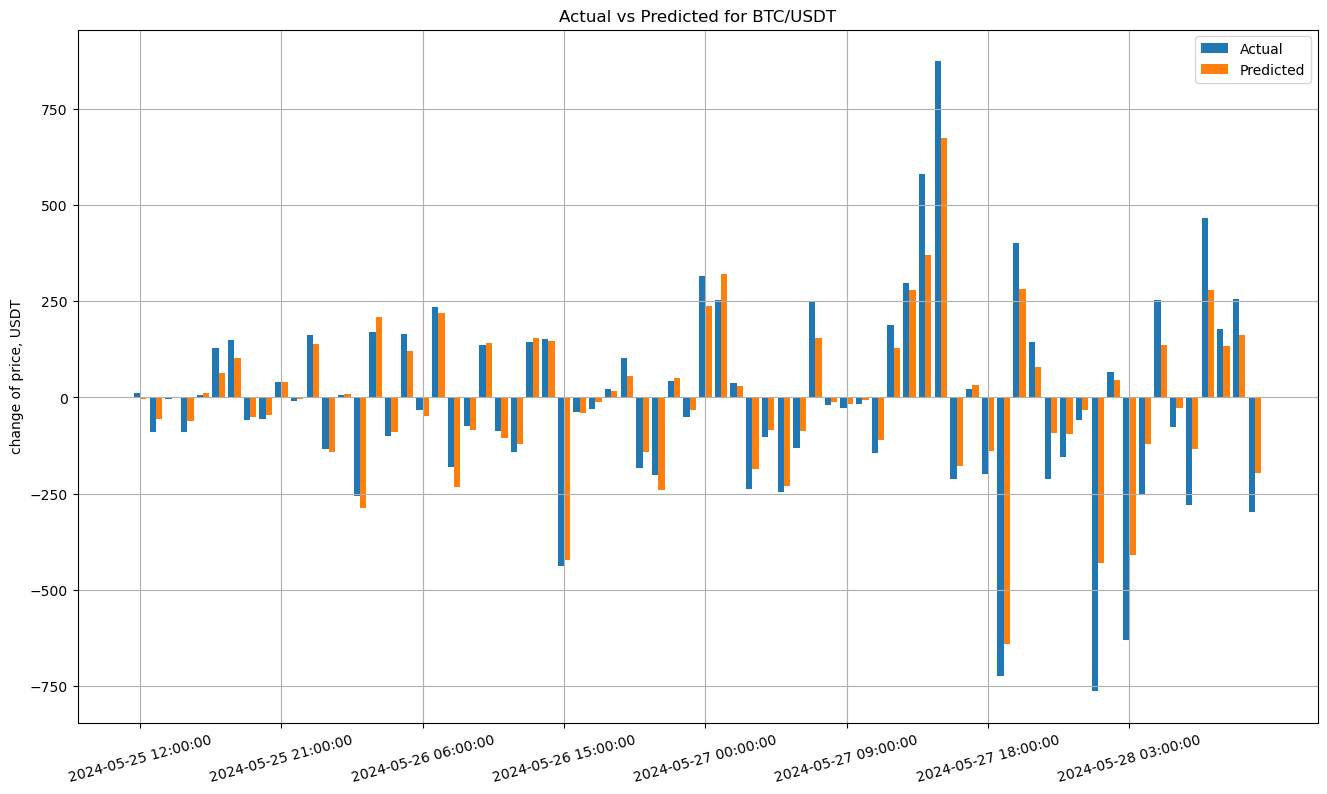

In [21]:
dataframe = fetch_ohlcv(symbols[0], timeframe=timeframe, n_frames=n_hours)
    
# convert absolute values to relative values
dataframe = dataframe.diff()

# Prepare data for machine learning
dataframe = dataframe.dropna()  # Drop rows with NaN values

# Check if data is not empty after dropping NaN values
print(f"Data for {symbols[0]} after dropping NaN values:")
print(dataframe.shape)
if dataframe.empty:
    raise ValueError(f"Dataframe for {symbols[0]} is empty after dropping NaN values. Check data fetching and indicator calculation steps.")

model = MLPRegressor(hidden_layer_sizes=(125, 125), max_iter=1000, alpha=0.002,learning_rate='adaptive',tol=0.002, learning_rate_init=0.002, random_state=42)
X = dataframe.drop(['close'], axis=1)
y = dataframe['close']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
tscv = TimeSeriesSplit(n_splits=40)
predictions = []
R2 = []
RSS = []
MAE = []
loss = []

for train_index, test_index in tscv.split(X_scaled):
    X_train = scaler.fit_transform(X.values[train_index])
    X_test = scaler.fit_transform(X.values[test_index])
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions.extend(y_pred)
    R2.append( r2_score(y_test, y_pred) )
    RSS.append( np.sum( np.square(y_test - y_pred) ) )
    MAE.append( mean_absolute_error(y_test, y_pred) )
    loss.append(model.loss_)

# Plotting the results
fig, ax = plt.subplots(figsize=(16, 9))
x_temp = np.arange(len(dataframe.index[-len(predictions):]))
w = 0.4
ax.bar(x_temp[-72:] - w/2, y.iloc[-72:], width=w, label="Actual")
ax.bar(x_temp[-72:] + w/2, predictions[-72:], width=w, label="Predicted")
ax.set_ylabel("change of price, USDT")
ax.set_xticks(x_temp[-72:])
ax.set_xticklabels(dataframe.index[-72:].astype(str), rotation=15)
plt.locator_params(axis="x", nbins=8)
ax.grid(True)
ax.set_title(f"Actual vs Predicted for {symbols[0]}")
ax.legend()
plt.show()

## wykres R2

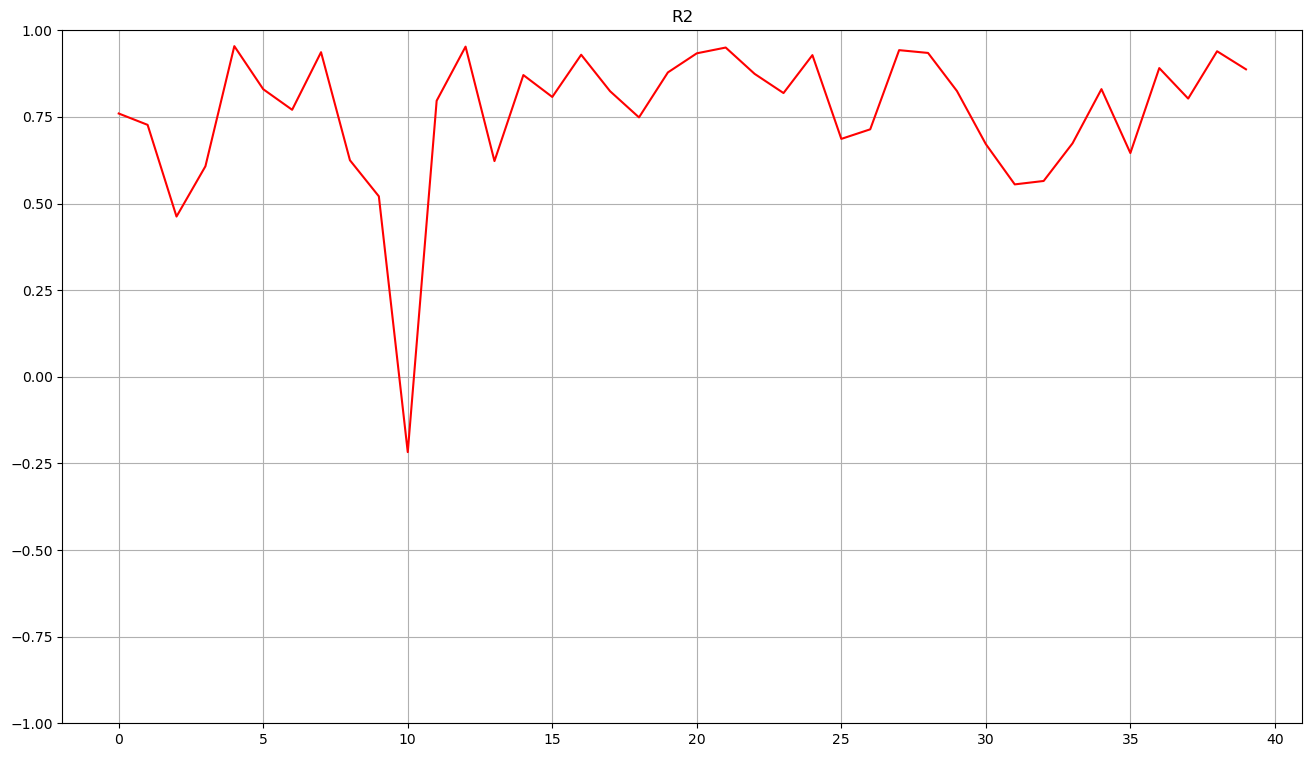

In [8]:
plt.figure(figsize=(16,9))
plt.title("R2")
plt.plot(R2, "r")
plt.ylim([-1,1])
plt.grid(True)
plt.show()

## porównanie RSS i MAE

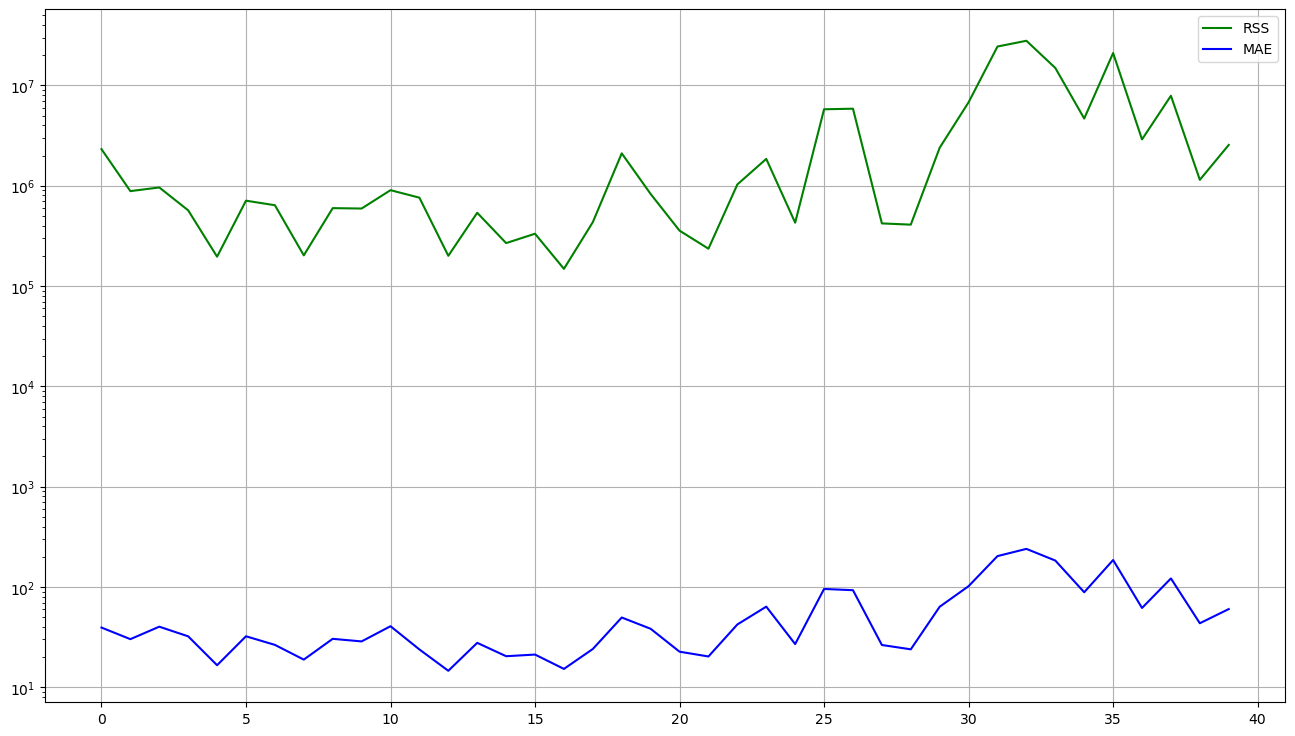

In [9]:
plt.figure(figsize=(16,9))
plt.plot(RSS, "g")
plt.plot(MAE, "b")
plt.yscale("log")
plt.legend(["RSS", "MAE"])
plt.grid(True)
plt.show()

## wykres funkcji straty

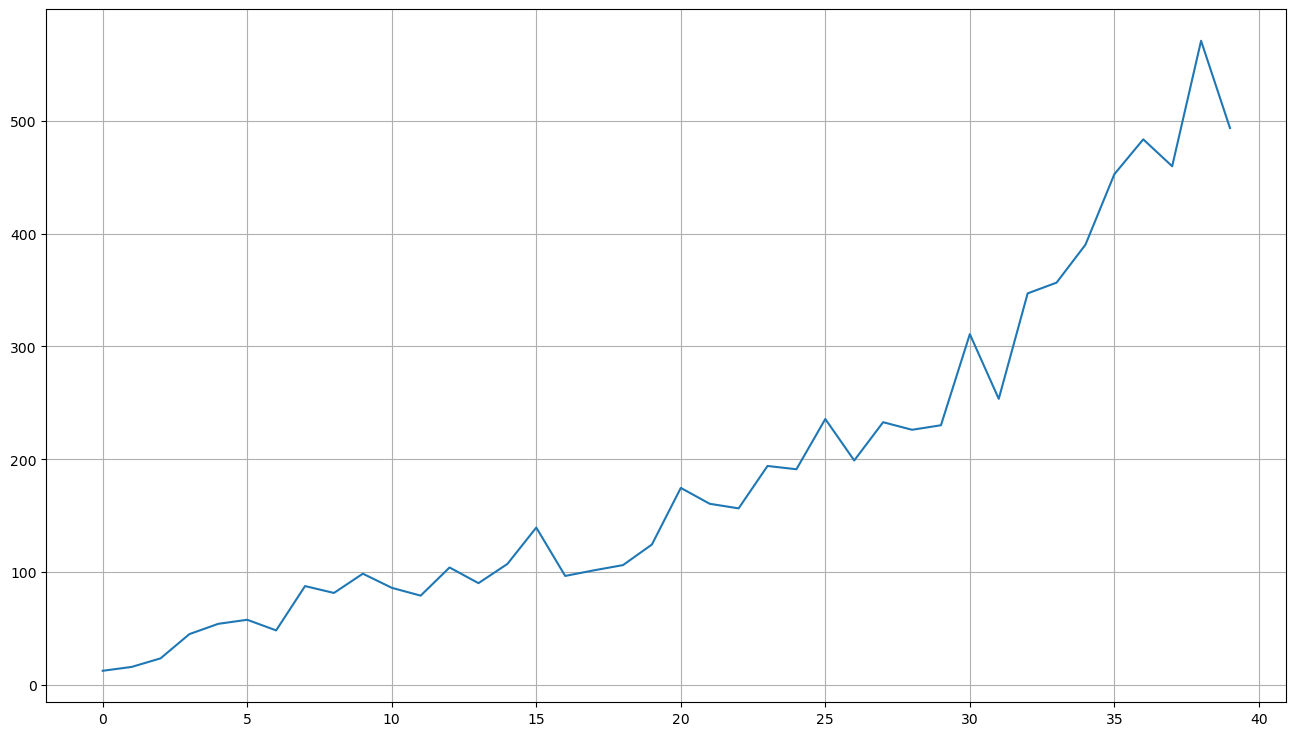

In [23]:
plt.figure(figsize=(16,9))
plt.plot(loss)
plt.grid(True)
plt.show()

## wykres różnic między faktyczną a przewidywaną zmianą 

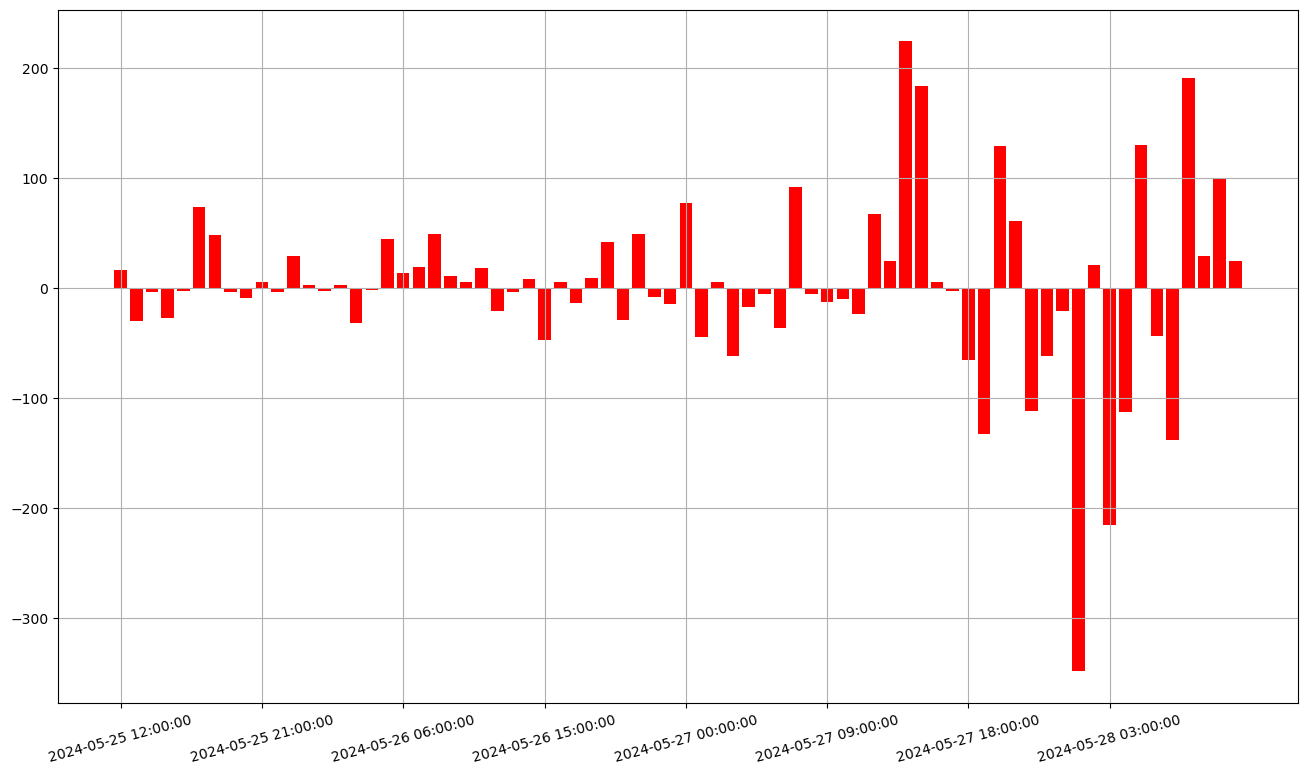

In [10]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(x_temp[-72:], y.iloc[-72:]-predictions[-72:], color="red")
ax.set_xticks(x_temp[-72:])
ax.set_xticklabels(dataframe.index[-72:].astype(str), rotation=15)
ax.grid(True)
plt.locator_params(axis="x", nbins=8)
plt.show()

# **wizualizacja - Cross-Validation, K-fold**

C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\3379696891.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])
C:\Users\vdi-student\AppData\Local\Temp\ipykernel_10632\3379696891.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])


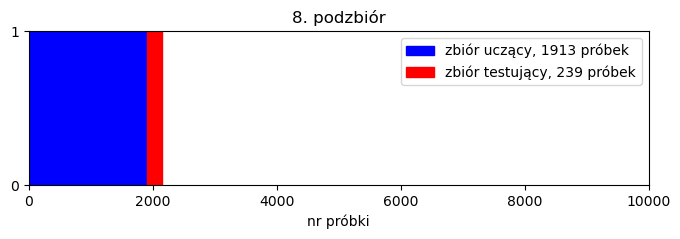

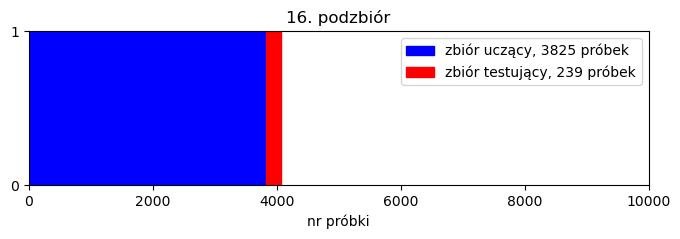

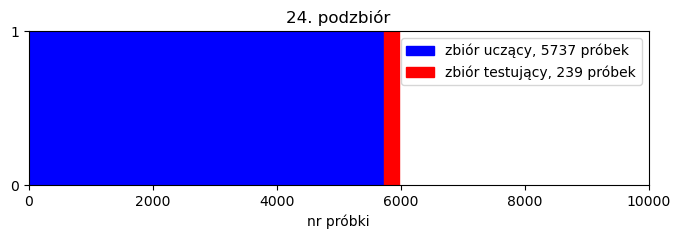

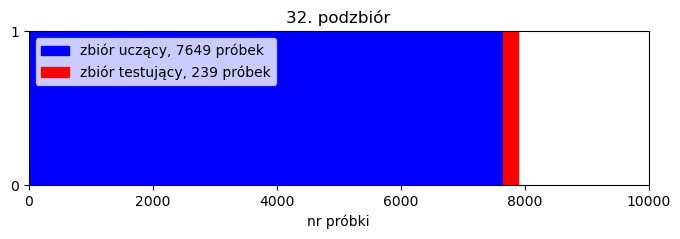

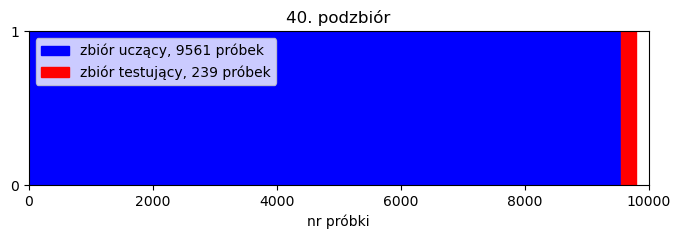

In [16]:
dataframe = fetch_ohlcv(symbols[0], timeframe=timeframe, n_frames=n_hours)
dataframe = dataframe.diff()
dataframe = dataframe.dropna()
X = dataframe.drop(['close'], axis=1)

tscv = TimeSeriesSplit(n_splits=40)
for i, (train_ind, test_ind) in enumerate(tscv.split(X)):
    if (i%8==7):
        fig, ax = plt.subplots(figsize=(8,2))
        ax.set_title(f"{i+1}. podzbiór")
        ax.axvspan(train_ind[0], test_ind[0], color="b")
        ax.axvspan(test_ind[0], test_ind[-1], color="r")
        ax.set_xlim([0,n_hours])
        #ax.set_xlim([0,(n_hours*(i+2)/40)])
        ax.set_xlabel("nr próbki")
        ax.set_yticks([0,1])
        ax.legend([f"zbiór uczący, {len(train_ind)} próbek", f"zbiór testujący, {len(test_ind)} próbek"])
        plt.show

# macierze korelacji

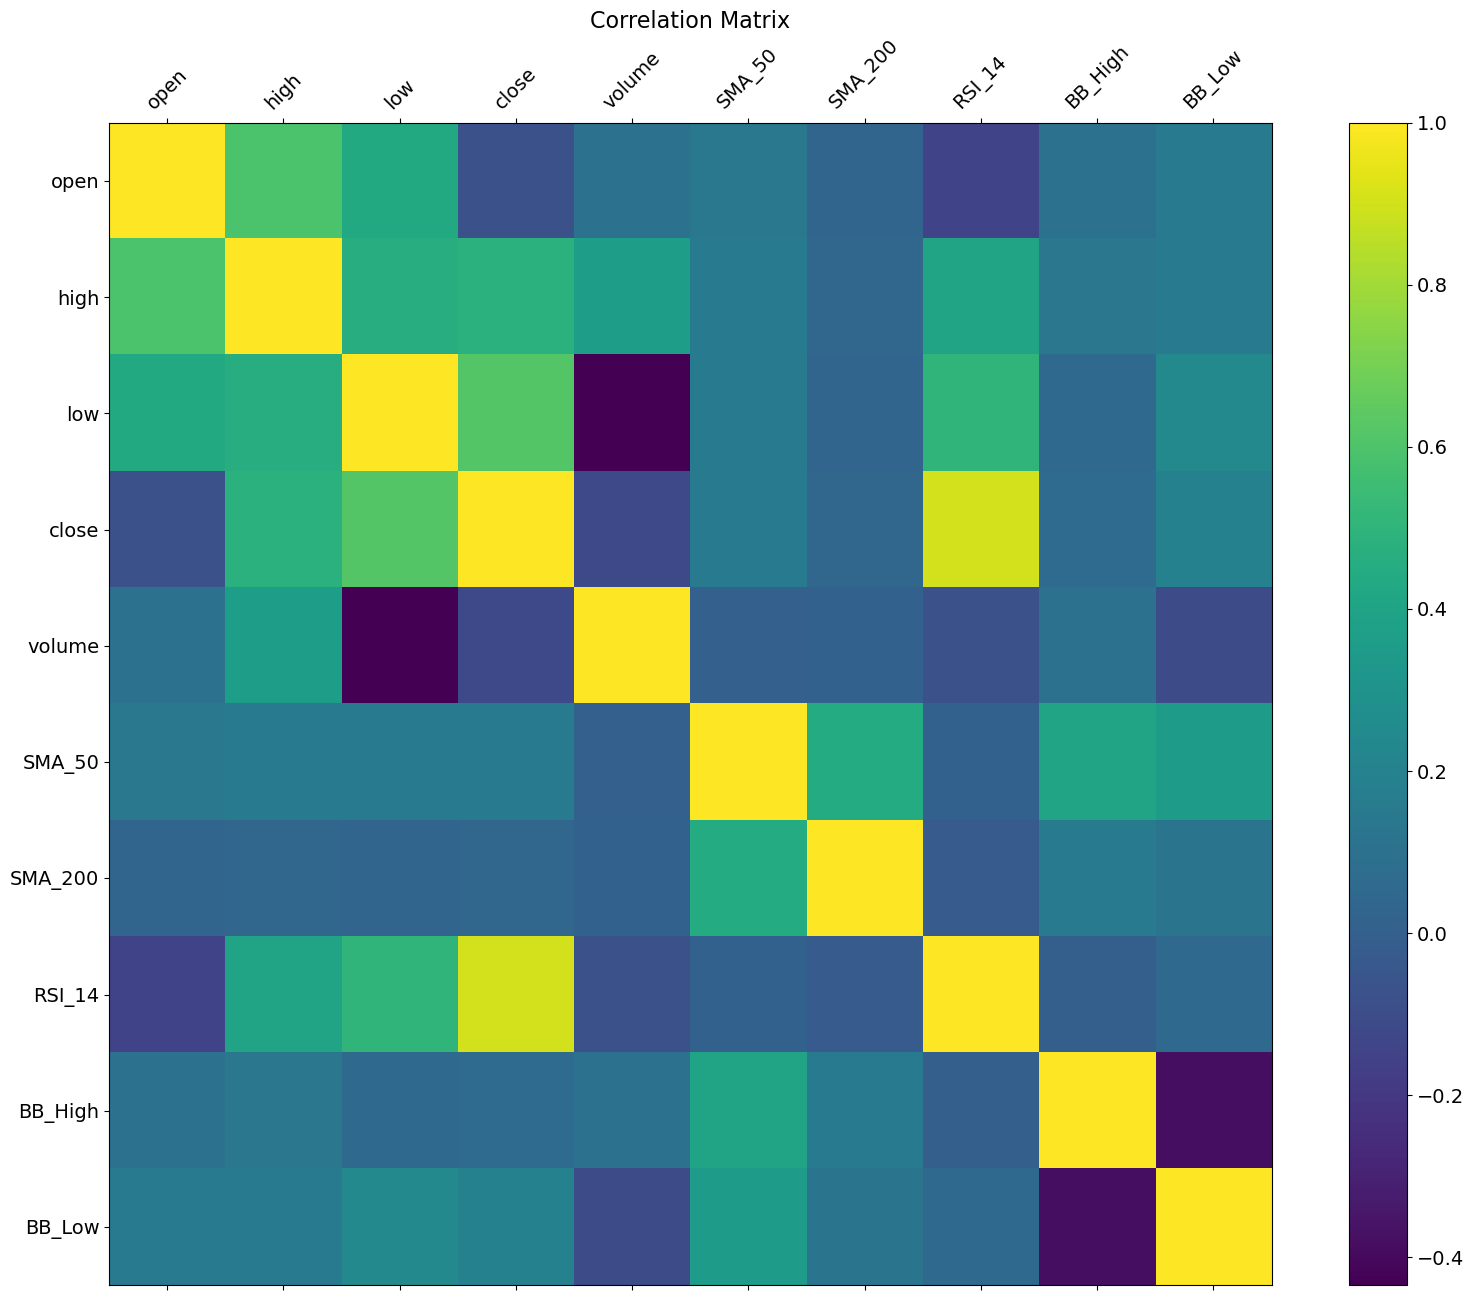

In [36]:
def plot_correlation(df):
    f = plt.figure(figsize=(20, 15))
    ax = plt.matshow(corr, fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #ax.set_ylim([0,2])
    plt.title('Correlation Matrix', fontsize=16);
    
corr=dataframe.corr()
plot_correlation(dataframe)

In [35]:
corr.style.background_gradient(cmap='coolwarm')

,open,high,low,close,volume,SMA_50,SMA_200,RSI_14,BB_High,BB_Low
open,1.000000,0.592384,0.435977,-0.077305,0.108458,0.140167,0.034632,-0.145266,0.107259,0.151225
high,0.592384,1.000000,0.461044,0.484140,0.361588,0.157675,0.040891,0.401368,0.133584,0.151230
low,0.435977,0.461044,1.000000,0.615343,-0.434277,0.159871,0.033238,0.506137,0.058442,0.242050
close,-0.077305,0.484140,0.615343,1.000000,-0.118976,0.155897,0.040977,0.902630,0.066618,0.198750
volume,0.108458,0.361588,-0.434277,-0.118976,1.000000,0.007762,0.012049,-0.079482,0.108350,-0.102544
SMA_50,0.140167,0.157675,0.159871,0.155897,0.007762,1.000000,0.448897,0.012360,0.400764,0.361146
SMA_200,0.034632,0.040891,0.033238,0.040977,0.012049,0.448897,1.000000,-0.022936,0.161281,0.117177
RSI_14,-0.145266,0.401368,0.506137,0.902630,-0.079482,0.012360,-0.022936,1.000000,0.001154,0.057754
BB_High,0.107259,0.133584,0.058442,0.066618,0.108350,0.400764,0.161281,0.001154,1.000000,-0.379635
BB_Low,0.151225,0.151230,0.242050,0.198750,-0.102544,0.361146,0.117177,0.057754,-0.379635,1.000000
